(supervised:text-classification:preprocessing)=
# Preprocessing Text Data

We want to classify blog posts by age and gender of the post's author. Training data is available from [The Blog Authorship Corpus](https://u.cs.biu.ac.il/~koppel/BlogCorpus.htm), containing 650000 posts from 19000 blogs. Data may be freely used for non-commercial research purposes. Data was collected for research published in [Effects of Age and Gender on Blogging](https://u.cs.biu.ac.il/~schlerj/schler_springsymp06.pdf) (J. Schler, M. Koppel, S. Argamon, J. Pennebaker, Proceedings of 2006 AAAI Spring Symposium on Computational Approaches for Analyzing Weblogs).

In addition to usual preprocessing and model training we will discuss how to convert text data to numerical features and how to cope with very high dimensional feature spaces. Models will be based on word counts. This first chapter contains everything we need to do before counting words. The second chapter discusses how to count words and how to use word counts for training machine learning models.

In [1]:
data_path = '/data/datasets/blogs/'

## Getting and Restructuring the Data Set

Data comes as ZIP file from the above mentioned website (313 MB). The ZIP file contains one [XML](https://en.wikipedia.org/wiki/XML) file per blog (uncompressed size is 808 MB). An XML file is a text file containing some markup code (similar to HTML). Information about a blog's author is provided in the file name.

### Extracting Blog Information

File names have the format `blog_id.gender.age.industry.astronomical_sign.xml`. We create a data frame containing all the information but astronomical signs and save it to a CSV file.

In [2]:
import pandas as pd
import numpy as np
import zipfile
import re
import langdetect

In [3]:
with zipfile.ZipFile(data_path + 'blogs.zip') as zf:
    file_names = zf.namelist()
    
print(file_names[:5])

['blogs/', 'blogs/1000331.female.37.indUnk.Leo.xml', 'blogs/1000866.female.17.Student.Libra.xml', 'blogs/1004904.male.23.Arts.Capricorn.xml', 'blogs/1005076.female.25.Arts.Cancer.xml']


XML files are in a subdirectory and the subdirectory is listed by `zf.namelist()`, too.

In [4]:
blog_ids = []
genders = []    # 'm' if male, 'f' if female
ages = []
industries = []

for file_name in file_names:
    
    if file_name.split('.')[-1] != 'xml':
        print('skipping', file_name)
        continue
    
    blog_id, gender, age, industry, astro = file_name.split('/')[-1].split('.')[0:-1]

    blog_ids.append(int(blog_id))
    
    if gender == 'male':
        genders.append('m')
    elif gender == 'female':
        genders.append('f')
    else:
        print('unknown gender:', gender)
        
    ages.append(int(age))
    
    industries.append(industry)

blogs = pd.DataFrame({'gender': genders, 'age': ages, 'industry': industries}, index=blog_ids)

skipping blogs/


In [5]:
blogs

gender  age            industry
1000331      f   37              indUnk
1000866      f   17             Student
1004904      m   23                Arts
1005076      f   25                Arts
1005545      m   25         Engineering
...        ...  ...                 ...
996147       f   36  Telecommunications
997488       m   25              indUnk
998237       f   16              indUnk
998966       m   27              indUnk
999503       m   25            Internet

[19320 rows x 3 columns]

In [6]:
blogs['industry'] = blogs['industry'].str.replace('indUnk', 'unknown')

In [7]:
blogs

gender  age            industry
1000331      f   37             unknown
1000866      f   17             Student
1004904      m   23                Arts
1005076      f   25                Arts
1005545      m   25         Engineering
...        ...  ...                 ...
996147       f   36  Telecommunications
997488       m   25             unknown
998237       f   16             unknown
998966       m   27             unknown
999503       m   25            Internet

[19320 rows x 3 columns]

In [8]:
blogs.to_csv(data_path + 'blogs.csv')

### Converting XML Files to one CSV File

We would like to have a data frame containing all blog posts. This data frame can easily be modified (data preprocessing!) and saved to a CSV file for future use.

Reading XML files can be done with the module [`xml.etree.ElementTree`](https://docs.python.org/3/library/xml.etree.elementtree.html) from the standard python library. Usage is relatively simple but the parser gets stuck at almost all files. Although file extension is XML the files do not contain valid XML. Most files contain characters not allowed in XML files and some files even contain HTML fragments, which make the parser fail. Thus, we have to parse files manually.

The structure of the files is as follows:
```xml
<Blog>
<date>DAY,MONTH_NAME,YEAR</date>
<post>TEXT_OF_POST</post>
...
<date>DAY,MONTH_NAME,YEAR</date>
<post>TEXT_OF_POST</post>
</Blog>
```
When parsing the files we have to take into account the following observations:
* Files are littered with random white space characters.
* Enconding is unknown and may vary from file to file.
* Files contain non-printable characters (00h-1Fh) other than line breaks (could be an encoding issue).
* Links in original posts are marked by `urlLink` (not `urllink` as indicated in the data set description).

White space can be removed with `str.strip()`. At least some files are not Unicode encoded. Interpreting non-Unicode files as Unicode may lead to errors. Using a 1-byte-encoding like ASCII or ISO 8859-1 also works for UTF-8 files, because each byte is interpreted as some character. Using a 1-byte-encoding for UTF-8 files may result in non-printable characters, which have to be removed before further processing of the text data. Removing all non-printable characters also removes line breaks. But line breaks do not matter for our classification task. So that's not a problem. The link marker `urlLink` can be savely removed. Possible URLs following the marker are hard to remove. For the moment we keep them.

Months in the date field are given by name, mostly in English but also in some other languages. To translate month names to numbers we use a dictionary. To get the dictionary we may start with English month names and then add more names one by one, if program stops with key error. Here is a list of languages and one XML file per language:

| language | file |
|:-----|:-----|
|French|1022086.female.17.Student.Cancer.xml|
|Spanish|1162265.male.17.Student.Aries.xml|
|Portuguese|1253219.female.27.indUnk.Sagittarius.xml|
|German|1366984.female.25.Technology.Aries.xml|
|Estonian|1405766.male.24.HumanResources.Scorpio.xml|
|Italian|1847277.female.24.Student.Gemini.xml|
|Finnish|2042296.female.25.Student.Sagittarius.xml|
|Dutch|3032299.female.33.Non-Profit.Scorpio.xml|
|Polish|3340219.male.45.Technology.Virgo.xml|
|Romanian|3559973.female.36.Manufacturing.Aries.xml|
|Swedish|4145017.male.23.BusinessServices.Libra.xml|
|Russian|4230660.female.13.Student.Virgo.xml|
|Croatian|817097.female.26.Student.Taurus.xml|
|Norwegian|887044.female.23.indUnk.Pisces.xml|

Some dates are missing with `,,` in the date field. We set such dates to `0/0/0`.

Looking at some of the XML files with non-English month names we see that there are some post written in languages other than English. The data set providers only checked whether a blog (not a post) contains at least 200 common English words. Thus, we have to remove some posts. Language detection can be done with the [`langdetect` module](https://github.com/Mimino666/langdetect).

In [9]:
# cell execution may take several hours due to language detection

month_num = {'january': 1, 'february': 2, 'march': 3, 'april': 4, 'may': 5, 'june': 6,
             'july': 7, 'august': 8, 'september': 9, 'october': 10, 'november': 11, 'december': 12,
             # French
             'janvier': 1, 'mars': 3, 'avril': 4, 'mai': 5, 'juin': 6,
             'juillet': 7, 'septembre': 9, 'octobre': 10, 'novembre': 11,
             # Spanish
             'enero': 1, 'febrero': 2, 'marzo': 3, 'abril': 4, 'mayo': 5, 'junio': 6,
             'julio': 7, 'agosto': 8, 'septiembre': 9, 'octubre': 10, 'noviembre': 11, 'diciembre': 12,
             # Portuguese
             'janeiro': 1, 'fevereiro': 2, 'maio': 5, 'junho': 6,
             'julho': 7, 'agosto': 8, 'setembro': 9, 'outubro': 10, 'novembro': 11, 'dezembro': 12,
             # German
             'januar': 1, 'februar': 2, 'märz': 3, 'april': 4, 'mai': 5, 'juni': 6,
             'juli': 7, 'august': 8, 'september': 9, 'oktober': 10, 'november': 11, 'dezember': 12,
             # Estonian
             'jaanuar': 1, 'aprill': 4, 'juuni': 6, 'juuli': 7,
             # Italian
             'giugno': 6, 'luglio': 7, 'ottobre': 10,
             # Finnish
             'toukokuu': 5, 'elokuu': 8,
             # Dutch
             'maart': 3, 'mei': 5, 'augustus': 8,
             # Polish
             'maj': 5, 'czerwiec': 6, 'lipiec': 7,
             # Romanian
             'ianuarie': 1, 'februarie': 2, 'iulie': 7, 'septembrie': 9, 'noiembrie': 11,
             # Swedish
             'augusti': 8,
             # Russian
             'avgust': 8,
             # Croatian
             'lipanj': 6, 'kolovoz': 8,
             # Norwegian
             'mars': 3, 'desember': 12,
             # unknown
             'unknown': 0}


blog_ids = []
days = []
months = []
years = []
texts = []
langs = []

with zipfile.ZipFile(data_path + 'blogs.zip') as zf:

    for file_name in zf.namelist():

        if file_name.split('.')[-1] != 'xml':
            print('skipping', file_name)
            continue

        #print(file_name)

        blog_id = int(file_name.split('/')[-1].split('.')[0])

        with zf.open(file_name) as f:
            xml = f.read().decode(encoding='iso-8859-1')

        xml_posts = xml.split('<date>')[1:]

        for xml_post in xml_posts:

            day, month, year = xml_post[:(xml_post.find('</date>'))].split(',')
            if len(day) == 0:
                day = '0'
            if len(month) == 0:
                month = 'unknown'
            if len(year) == 0:
                year = '0'

            text = xml_post[(xml_post.find('<post>') + 6):(xml_post.find('</post>'))]
            text = re.sub(r'[\x00-\x1F]+', ' ', text)    # non-printable characters
            text = text.replace('&nbsp;', ' ')    # HTML entity for protected spaces
            text = text.replace('urlLink', '')    # link marker
            text = text.strip()

            try:
                lang = langdetect.detect(text)                
            except langdetect.LangDetectException:
                lang = ''
                
            if len(text) > 0:
                blog_ids.append(blog_id)
                days.append(int(day))
                months.append(month_num[month.lower()])
                years.append(int(year))
                texts.append(text)
                langs.append(lang)
        
posts = pd.DataFrame(data={'blog_id': blog_ids, 'day': days, 'month': months, 'year': years,
                           'text': texts, 'lang': langs})
posts

skipping blogs/


blog_id  day  month  year  \
0       1000331   31      5  2004   
1       1000331   29      5  2004   
2       1000331   28      5  2004   
3       1000331   28      5  2004   
4       1000331   28      5  2004   
...         ...  ...    ...   ...   
676023   999503    4      7  2004   
676024   999503    3      7  2004   
676025   999503    2      7  2004   
676026   999503    1      7  2004   
676027   999503    1      7  2004   

                                                     text lang  
0       Well, everyone got up and going this morning. ...   en  
1       My four-year old never stops talking.  She'll ...   en  
2       Actually it's not raining yet, but I bought 15...   en  
3       Ha! Just set up my RSS feed - that is so easy!...   en  
4       Oh, which just reminded me, we were talking ab...   en  
...                                                   ...  ...  
676023  Today we celebrate our independence day.    In...   en  
676024  Ugh, I think I have allergies...  My nose has ...   en  
676025  "Science is like sex; occasionally something p...   en  
676026  Dog toy or marital aid   I managed 10/14 on th...   en  
676027  I had a dream last night about a fight when I ...   en  

[676028 rows x 6 columns]

In [10]:
print(len(posts))

posts = posts.loc[posts['lang'] == 'en', :]
posts = posts.drop(columns=['lang'])

print(len(posts))

676028
653764


In [11]:
posts.to_csv(data_path + 'posts.csv')

In [12]:
posts = pd.read_csv(data_path + 'posts.csv', index_col=0)

posts

blog_id  day  month  year  \
0       1000331   31      5  2004   
1       1000331   29      5  2004   
2       1000331   28      5  2004   
3       1000331   28      5  2004   
4       1000331   28      5  2004   
...         ...  ...    ...   ...   
676023   999503    4      7  2004   
676024   999503    3      7  2004   
676025   999503    2      7  2004   
676026   999503    1      7  2004   
676027   999503    1      7  2004   

                                                     text  
0       Well, everyone got up and going this morning. ...  
1       My four-year old never stops talking.  She'll ...  
2       Actually it's not raining yet, but I bought 15...  
3       Ha! Just set up my RSS feed - that is so easy!...  
4       Oh, which just reminded me, we were talking ab...  
...                                                   ...  
676023  Today we celebrate our independence day.    In...  
676024  Ugh, I think I have allergies...  My nose has ...  
676025  "Science is like sex; occasionally something p...  
676026  Dog toy or marital aid   I managed 10/14 on th...  
676027  I had a dream last night about a fight when I ...  

[653702 rows x 5 columns]

## Exploring the Data Set

Now we have two data frames: `blogs` and `posts`. We should have a look at the data before tackling the learning task.

In [13]:
print('blogs:', len(blogs))
print('posts:', len(posts))

blogs: 19320
posts: 653702


### Exploring Blog Authors

In [15]:
blogs.groupby('gender').count()

age  industry
gender                
f       9660      9660
m       9660      9660

The data set is well balanced with respect to blog author's gender.

In [16]:
blogs.groupby('age').count()

gender  industry
age                  
13      690       690
14     1246      1246
15     1771      1771
16     2152      2152
17     2381      2381
23     2026      2026
24     1895      1895
25     1620      1620
26     1340      1340
27     1205      1205
33      464       464
34      378       378
35      338       338
36      288       288
37      259       259
38      171       171
39      152       152
40      145       145
41      139       139
42      127       127
43      116       116
44       94        94
45      103       103
46       72        72
47       71        71
48       77        77

In [17]:
blogs['age'].hist(bins=np.arange(13, 49)-0.5)

<Axes: >

We have three age groups of different size:

In [18]:
print(np.count_nonzero((blogs['age'] < 20).to_numpy()))
print(np.count_nonzero(((blogs['age'] > 20) & (blogs['age'] < 30)).to_numpy()))
print(np.count_nonzero((blogs['age'] > 30).to_numpy()))

8240
8086
2994


According to the data set description gender should be balanced in each age group.

In [19]:
blogs['age_group'] = pd.cut(blogs['age'], bins=[0, 20, 30, 100])

blogs.groupby(['age_group', 'gender']).count()

/tmp/ipykernel_19434/2441672544.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  blogs.groupby(['age_group', 'gender']).count()


age  industry
age_group gender                
(0, 20]   f       4120      4120
          m       4120      4120
(20, 30]  f       4043      4043
          m       4043      4043
(30, 100] f       1497      1497
          m       1497      1497

In [20]:
blogs.groupby('industry').count()['age'].sort_values(ascending=False)

industry
unknown                    6827
Student                    5120
Education                   980
Technology                  943
Arts                        721
Communications-Media        479
Internet                    397
Non-Profit                  372
Engineering                 312
Government                  236
Law                         197
Consulting                  191
Science                     184
Marketing                   180
BusinessServices            163
Publishing                  150
Advertising                 145
Religion                    139
Telecommunications          119
Military                    116
Banking                     112
Accounting                  105
Fashion                      98
Tourism                      94
HumanResources               94
Transportation               91
Sports-Recreation            90
Manufacturing                87
Architecture                 69
Chemicals                    62
Biotech                      57

Industry is available for about 60 per cent of the blog authors.

### Exploring Blog Posts

Although for our classification task dates of posts are irrelevant, we have a look at them. Looking at irrelevant columns yields a better feeling for the data set and its reliability.

In [21]:
posts.groupby('year').count()

blog_id     day   month    text
year                                 
0          23      23      23      23
1999       68      68      68      68
2000      866     866     866     866
2001     5427    5427    5427    5427
2002    21772   21772   21772   21772
2003   100199  100199  100199  100199
2004   525318  525318  525318  525318
2005        6       6       6       6
2006       23      23      23      23

The data set providers scraped the data in August 2004. Thus, there should be no newer posts. Since we only are interested in post texts, we do not care about this inconsistency here.

In [22]:
posts.groupby('month').count()

blog_id     day    year    text
month                                 
0           23      23      23      23
1        21812   21812   21812   21812
2        24663   24663   24663   24663
3        29099   29099   29099   29099
4        33166   33166   33166   33166
5        75275   75275   75275   75275
6       125797  125797  125797  125797
7       154842  154842  154842  154842
8       125919  125919  125919  125919
9        13051   13051   13051   13051
10       16296   16296   16296   16296
11       16525   16525   16525   16525
12       17234   17234   17234   17234

The maximum in summer months is not because people write more blog posts in summer. Blogging became more and more popular from month to month and posts had been collected till August 2004. Including posts from September 2004 we (presumable) would get September counts higher than August counts. Slight drop from July to August could be caused by incomplete data for August 2004.

<Axes: xlabel='day'>

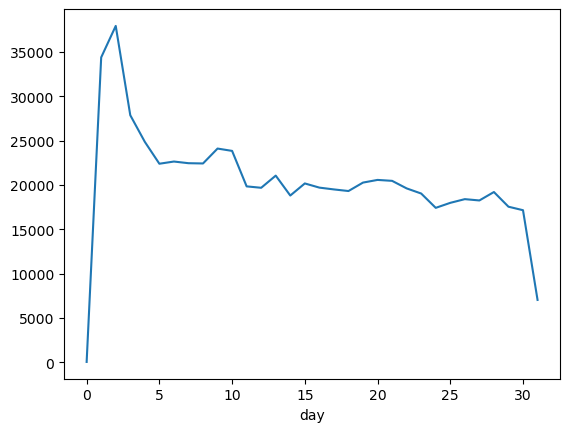

In [23]:
posts.groupby('day').count()['blog_id'].plot()

There are more posts at the beginning of a month than at a month's end. Counts for 31st are much lower because not every month has a 31st.

We should have a look at class balancing. We already know that gender is well balanced and age is not if we count on a per-blog basis. But since we want to classify blog posts (not complete blogs) by gender and age of the author we have to consider class sizes on a per post-basis.

In [24]:
posts_per_blog = posts.groupby('blog_id')['day'].count()

blogs['posts'] = 0
blogs.loc[posts_per_blog.index, 'posts'] = posts_per_blog

blogs.groupby(['gender', 'age_group'])['posts'].sum()

/tmp/ipykernel_19434/1016594775.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  blogs.groupby(['gender', 'age_group'])['posts'].sum()


gender  age_group
f       (0, 20]      110387
        (20, 30]     155425
        (30, 100]     56786
m       (0, 20]      115255
        (20, 30]     152739
        (30, 100]     63110
Name: posts, dtype: int64

In the highest age group gender is somewhat unbalanced, but not much. An even more accurate measure of class size (data per class) is the cummulated text length per class.

In [25]:
posts['length'] = posts['text'].str.len()
chars_per_blog = posts.groupby('blog_id')['length'].sum()

blogs['chars'] = 0
blogs.loc[chars_per_blog.index, 'chars'] = chars_per_blog

blogs.groupby(['gender', 'age_group'])['chars'].sum()

/tmp/ipykernel_19434/1431541158.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  blogs.groupby(['gender', 'age_group'])['chars'].sum()


gender  age_group
f       (0, 20]      117123221
        (20, 30]     179750611
        (30, 100]     74878617
m       (0, 20]      119793206
        (20, 30]     175919412
        (30, 100]     72894990
Name: chars, dtype: int64

Here balancing of gender looks better, but again the highest age group is much smaller than the other two age groups.

## Preprocessing Text for Counting Words

Machine learning algorithms expect numbers as inputs. So we have to convert strings to vectors of numbers. There exist different conversion techniques, some advanced ones like [Word2vec](https://en.wikipedia.org/wiki/Word2vec) and some simpler ones like the *bag of words* approach. The latter assigns each word in a corpus a position in a vector and represents a string by counting the occurrences of each word. The vector representation of a string is the vector containing all word counts.

Input features are word counts and length of feature vectors equals the number of different words in a dictionary. Thus, feature vectors are extremely long and contain zeros almost everywhere. Vectors containing zeros almost everywhere are called *sparse vectors*. A sparse vectors is not stored as array, but as list of index-value pairs for non-zero components only. Memory consumption is not given by vector length but by the number of non-zero components. Scikit-Learn and NumPy support sparse vectors (and matrices) and automatically choose a suitable data type where appropriate.

The dictionary (and, thus, the feature space dimension) is determined from the training set. All words contained in the training set form the dictionary. Usually one leaves out words occurring only in very few training samples or words occurring in almost all training samples. From the former a model cannot learn something useful due to lack of samples. The latter do not contain useful information to discriminate between different classes.

Before converting strings to vectors some preprocessing is necessary. At least punctuation and other special characters should be removed. Other preprocessing steps may include:
* *Stop word removal:* Remove common words like 'and', 'or', 'have'. There exist list of stop words for most languages. Stop word removal has to be used with care, because some common words may contain important information, like 'not' for instance.
* *Stemming:* Remove word endings like plural 's' or 'ing' to get word stems. There exist many different stemming algorithms. Results are sometimes incorrect. For instance, 'thus' is usually stemmed to 'thu'.
* *Lemmatization:* Get the base form of a word. It's a more intelligent form of stemming, but requires lots of computation time. Again, there exist many different algorithms.

Stop words, stemming, and lemmatization are, for instance, implemented in the [`nltk` Python package (Natural Language Toolkit)](https://www.nltk.org). The subject is known as *natural language processing*.

### Removing Punctuation and other Special Characters

We remove all characters but A-Z, numbers, single spaces, and basic punctuation (!, ?, dot, comma, aposthrophe). [Regular expressions](https://docs.python.org/3/library/re.html#regular-expression-syntax) allow for efficient removal.

In [26]:
posts['text'] = posts['text'].str.replace(r"[^\w ,\.\?!']", '', regex=True)

posts['text'] = posts['text'].str.replace(r'\s+', ' ', regex=True)

In [27]:
posts['text']

0         Well, everyone got up and going this morning. ...
1         My fouryear old never stops talking. She'll sa...
2         Actually it's not raining yet, but I bought 15...
3         Ha! Just set up my RSS feed that is so easy! W...
4         Oh, which just reminded me, we were talking ab...
                                ...                        
676023    Today we celebrate our independence day. In ho...
676024    Ugh, I think I have allergies... My nose has b...
676025    Science is like sex occasionally something pra...
676026    Dog toy or marital aid I managed 1014 on this ...
676027    I had a dream last night about a fight when I ...
Name: text, Length: 653702, dtype: object

Maybe some texts are empty now. We should remove them.

In [28]:
print(len(posts))

posts = posts.loc[posts.loc[:, 'text'] != '', :]

print(len(posts))

653702
653702


### Lemmatization

To reduce dictionary size and increase chances for good classification results we use lemmatization. For instance we want to count 'child' and 'children' as one and the same word. We choose the [`WordNetLemmatizer`](https://www.nltk.org/api/nltk.stem.wordnet.html) of NLTK. [WordNet](https://wordnet.princeton.edu) is a database provided by Princeton University which contains relations between English words.

The `WordNetLemmatizer` takes a word and looks it up in the data base. If it is found there, it returns the base form, else the original word is returned. WordNet data base can be [searched online](http://wordnetweb.princeton.edu/perl/webwn), too. Searching WordNet database with NLTK or online includes some stemming-like [preprocessing steps](https://wordnet.princeton.edu/documentation/morphy7wn).

In [29]:
import nltk

Before first use of `WordNetLemmatizer` we have to download the database.

In [30]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /var/lib/u21302575108/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

We have to create a `WordNetLemmatizer` object and then call its `lemmatize` method.

In [31]:
lemmatizer = nltk.stem.WordNetLemmatizer()

In [32]:
lemmatizer.lemmatize('child')

'child'

In [33]:
lemmatizer.lemmatize('children')

'child'

Note that the WordNet lemmatizer only works for lower case words (a not well documented fact).

In [34]:
lemmatizer.lemmatize('Children')

'Children'

Simply calling `WordNetLemmatizer` with some word may yield unexpected results. Given the sentence 'He is killing him.' we would expect 'killing' to be lemmatized to 'kill'.

In [35]:
lemmatizer.lemmatize('killing')

'killing'

The problem here is that 'killing' is the base form of a noun ('That resulted in a killing.') and `WordNetLemmatizer` by default looks for nouns. A second argument to `lemmatize` modifies the default behavior.

In [36]:
lemmatizer.lemmatize('killing', pos=nltk.corpus.reader.wordnet.VERB)

'kill'

The abbreviation 'pos' stands for 'part of speech'. The module `nltk.corpus.reader.wordnet` contains some WordNet related functionality. It defines some constants, for instance. Passing `nltk.corpus.reader.wordnet.NOUN` to `pos` (the default) tells the lemmatizer that the word is a noun. Passing `nltk.corpus.reader.wordnet.VERB` tells it that the word is a verb. Further options are `nltk.corpus.reader.wordnet.ADJ` (adjectives) and `nltk.corpus.reader.wordnet.ADV` (adverbs).

In [37]:
print(nltk.corpus.reader.wordnet.NOUN)
print(nltk.corpus.reader.wordnet.VERB)
print(nltk.corpus.reader.wordnet.ADJ)
print(nltk.corpus.reader.wordnet.ADV)

n
v
a
r


Although these are simple strings, we should use the constants. If implementation of NLTK oder WordNet changes, our code is more likely to remain working then.

The question now is: How to obtain POS information? NLTK implements several *POS taggers*. If you do not want to decide which one to choose, use the one recommended by NLTK by simply calling `pos_tag()`. This function takes a list of words and punctuation symbols as argument. Such a list can be generated by calling `word_tokenize()`. Again several tokenization algorithms are available and `word_tokenize()` uses the recommended one.

To use tokenization and tagging we have to download some NLTK data. The data to download may change if NLTK recommends other algorithms in future. But corresponding methods will show a warning if required data is not available and the warning message contains the code for downloading.

In [38]:
nltk.download('punkt')    # for tokenization
nltk.download('averaged_perceptron_tagger')    # for POS tagging

[nltk_data] Downloading package punkt to
[nltk_data]     /var/lib/u21302575108/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /var/lib/u21302575108/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Tokenization and tagging (in theory) could be implemented as follows.

In [39]:
posts['tokenized'] = None
posts['tagged'] = None

for idx in posts.index:
    posts.loc[idx, 'tokenized'] = nltk.tokenize.word_tokenize(posts.loc[idx, 'text'])
    posts.loc[idx, 'tagged'] = nltk.tag.pos_tag(posts.loc[idx, 'tokenized'])

ValueError: Must have equal len keys and value when setting with an iterable

This code results in an error which is somewhat hard to figure out. If on the right-hand side of an assignment to some Pandas object is an iterable, then Pandas expects a same-sized iterable on the left-hand side. Thus, it is not possible to assign, for instance, a list to a cell of a data frame. There exist several more or less complicated workarounds, which all are rather inefficient. Thus, we use the following code, which requires two for loops (list comprehensions) instead of one.

In [39]:
# cell execution takes several minutes

posts['tokenized'] = [nltk.tokenize.word_tokenize(text) for text in posts['text']]

In [40]:
posts['tokenized']

0         [Well, ,, everyone, got, up, and, going, this,...
1         [My, fouryear, old, never, stops, talking, ., ...
2         [Actually, it, 's, not, raining, yet, ,, but, ...
3         [Ha, !, Just, set, up, my, RSS, feed, that, is...
4         [Oh, ,, which, just, reminded, me, ,, we, were...
                                ...                        
676023    [Today, we, celebrate, our, independence, day,...
676024    [Ugh, ,, I, think, I, have, allergies, ..., My...
676025    [Science, is, like, sex, occasionally, somethi...
676026    [Dog, toy, or, marital, aid, I, managed, 1014,...
676027    [I, had, a, dream, last, night, about, a, figh...
Name: tokenized, Length: 653702, dtype: object

In [41]:
# cell execution takes an hour and requires 25 GB of memory

posts['tagged'] = [nltk.tag.pos_tag(tokens) for tokens in posts['tokenized']]

In [42]:
posts['tagged']

0         [(Well, RB), (,, ,), (everyone, NN), (got, VBD...
1         [(My, PRP$), (fouryear, JJ), (old, JJ), (never...
2         [(Actually, RB), (it, PRP), ('s, VBZ), (not, R...
3         [(Ha, NNP), (!, .), (Just, RB), (set, VBN), (u...
4         [(Oh, UH), (,, ,), (which, WDT), (just, RB), (...
                                ...                        
676023    [(Today, NN), (we, PRP), (celebrate, VBP), (ou...
676024    [(Ugh, NNP), (,, ,), (I, PRP), (think, VBP), (...
676025    [(Science, NN), (is, VBZ), (like, IN), (sex, N...
676026    [(Dog, NNP), (toy, NN), (or, CC), (marital, JJ...
676027    [(I, PRP), (had, VBD), (a, DT), (dream, NN), (...
Name: tagged, Length: 653702, dtype: object

The problem now is to translate NLTK POS tags to WordNet POS tags. Have a look at the list of [NLTK POS tags](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html). There we see the following relations:

| NLTK POS tag | WordNet POS tag |
|:----|:----|
| JJ... | ADJ |
| RB... | ADV |
| NN... | NOUN |
| VB... | VERB |

All NLTK POS tags have at least two characters. So we may use the following conversion function.

In [43]:
def NLTKPOS_to_WordNetPOS(tag):
    
    if tag[0:2] == 'JJ':
        return nltk.corpus.reader.wordnet.ADJ
    elif tag[0:2] == 'RB':
        return nltk.corpus.reader.wordnet.ADV
    elif tag[0:2] == 'NN':
        return nltk.corpus.reader.wordnet.NOUN
    elif tag[0:2] == 'VB':
        return nltk.corpus.reader.wordnet.VERB
    else:
        return None

Tokens with NLTK POS tags not present in WordNet can be removed, because they do not carry much information about the text. Here we have to keep in mind that our model will be based on word counts. So no relations between words are considered. For our model the sentence 'John is in the house.' will be the same as 'The house is in John'. For more advanced models, relations between words, and thus word classes other than adjectives, adverbs, verbs, nouns, may be of importance.

Note that the `lemmatize` function always returns some word. If a word is not found in the WordNet data base, then the orignal word is returned. If we want to sort out words not contained in WordNet we have use a trick. Looking at the [source code of `lemmatize`](https://www.nltk.org/_modules/nltk/stem/wordnet.html) we see that the function calls `nltk.corpus.wordnet._morphy`. The `_morphy` function returns a (possibly empty) list of lemmas found in WordNet. If `_morphy` returns an empty list, we know that the word under consideration is something unsual (contains typos, for instance) and should be ignored. Else we use the first lemma in the list.

In principle, this approach is good, but there's a snag to it: If we pass the wrong POS tag to `_morphy` we won't get a result.

In [44]:
nltk.corpus.wordnet._morphy('children', nltk.corpus.reader.wordnet.VERB)

[]

So we have to refine our strategy. If `_morphy` returns an empty list, we call `_morphy` with all possible POS tags. If all returned lists are empty, then we can be relatively sure that the word is something unsual and, thus, irelevant for our classification task.

Another issue is that WordNet does not lemmatize words containing apostrophes. For *she's* or *havn't* that's not a real problem, because such words are of little importance for our classification tasks. But what about *mama's*, for instance? We should remove all occurences of *'s*.

In [45]:
# cell execution may take several hours

print_max = 1000
printed = 0

posts['lemmatized'] = None

for idx in posts.index:
    lemmas = []    # list of all lemmatized words of current post
    for token, tag in posts.loc[idx, 'tagged']:
        modified_token = token.lower().replace("'s", '')
        
        wordnet_tag = NLTKPOS_to_WordNetPOS(tag)
        if not (wordnet_tag is None):
            
            morphy_result = nltk.corpus.wordnet._morphy(modified_token, wordnet_tag)
            if len(morphy_result) > 0:
                lemmas.append(morphy_result[0])
            else:
                morphy_result_all = nltk.corpus.wordnet._morphy(modified_token, nltk.corpus.reader.wordnet.NOUN) \
                                    + nltk.corpus.wordnet._morphy(modified_token, nltk.corpus.reader.wordnet.VERB) \
                                    + nltk.corpus.wordnet._morphy(modified_token, nltk.corpus.reader.wordnet.ADJ) \
                                    + nltk.corpus.wordnet._morphy(modified_token, nltk.corpus.reader.wordnet.ADV)
                if len(morphy_result_all) > 0:
                    lemmas.append(morphy_result_all[0])
                else:
                    if printed < print_max:
                        print(modified_token, end=', ')
                        printed += 1
                    
    posts.loc[idx, 'lemmatized'] = ' '.join(lemmas)
    
posts['lemmatized']

everyone, , , everything, .., fouryear, ummm, ...., ummm, anything, , goldeyes, n't, skydome, occassionally, goldeyes, n't, 'm, , n't, everyone, gameboy, n't, n't, n't, everything, 've, hmm, something, else, mcnally, something, anyone, 've, 've, breadmaker, n't, n't, 've, imdb, everything, something, something, 'm, ineveitable, n't, , n't, 'm, 've, kel, 'm, ya, di, amore, 'm, .., n't, n't, heh, , everyone, sleepyland, n't, 'm, ya, di, amore, whoopie, 've, umm, n't, epvm, n't, poopeyhead, nathan, 're, n't, nathan, nathan, alstadt, we, we, dan, dave, we, dan, , , .., n't, 'm, thnk, 'm, epvm, umm, heh, n't, arg, , 'm, 'm, madsen, eek, umm, .., brett, alex, joanne, now.they, 're, alex, , gosh, darnit, improv, 'm, 'm, 're, n't, ...., ya, di, amore, 'm, 'm, n't, ya, di, amore, , something, grrr, , 'm, enjoyig, hey, catie, momly, n't, duper, n't, 'm, anyone, 'm, , thingamabobber, 're, 're, 're, 've, di, amore, n't, 'm, 'm, , everyone, brandon, jake, n't, meh, , ok., my, n't, a., 'm, kane, umm

0         well get up go morning still raining okay sort...
1         old never stop talk say mom say say oh yeah do...
2         actually not raining yet buy ticket game mom b...
3         ha just set r feed be so easy do do enough tod...
4         just remind be talk can food coffee break morn...
                                ...                        
676023    today celebrate independence day honor event g...
676024    think have allergy nose have be stuff week mak...
676025    science be sex occasionally practical come not...
676026    dog toy marital aid manage little quiz see wel...
676027    have dream last night fight be younger dad hea...
Name: lemmatized, Length: 653702, dtype: object

In [46]:
posts = posts[['blog_id', 'lemmatized']]

posts.to_csv(data_path + 'posts_lemmatized.csv')

In [47]:
posts

blog_id                                         lemmatized
0       1000331  well get up go morning still raining okay sort...
1       1000331  old never stop talk say mom say say oh yeah do...
2       1000331  actually not raining yet buy ticket game mom b...
3       1000331  ha just set r feed be so easy do do enough tod...
4       1000331  just remind be talk can food coffee break morn...
...         ...                                                ...
676023   999503  today celebrate independence day honor event g...
676024   999503  think have allergy nose have be stuff week mak...
676025   999503  science be sex occasionally practical come not...
676026   999503  dog toy marital aid manage little quiz see wel...
676027   999503  have dream last night fight be younger dad hea...

[653702 rows x 2 columns]

In [48]:
posts_lemmatized = pd.read_csv(data_path + 'posts_lemmatized.csv', index_col=0, nrows=100)

posts['lemmatized'] = posts_lemmatized['lemmatized']

In [50]:
idx = 0

print(posts.loc[0, 'lemmatized'])

well get up go morning still raining okay sort suit mood easily have stay home bed book cat have be lot rain people have wet basement be lake be golf course fields be green green green be suppose be degree friday be deal mosquito next week hear winnipeg describe old testament city cbc radio one last week sort rings true flood infestation


We could improve preprocessing by tagging geographical locations, names of persons, and so on. But somewhere one has to stop. Let's see what a machine learning model can learn from our (not perfectly) preprocessed data...